# <center> Teamfight Tactics, <br> and  Predicting Team <br> Placement in a Game </center>

#### <center>Samuel Kahan</center>

## <center>Introduction</center>

Teamfight Tactics (TFT) is a multiplayer auto-battler game developed by Riot Games. An 'auto-battler' is a type of strategy game where players build a team of characters and then let the game play out battles automatically between different teams. TFT combines aspects of other games like chess, poker, and League of Legends into one. The game is broken up into rounds. There are three types of rounds:

    - PVP Rounds
    - PVE Rounds
    - Carousels

During PVP and PVE rounds, each player is presented with a shop of five units which they can purchase. They can then place these units onto their battlefield. Buying three of the same unit combines them into one silver unit, and three silver units combine to make a golden unit, each stronger than the last. Units have many stats, but the most important ones are generally HP and mana. When a unit's HP hits 0, it's eliminated from the battlefiend. When a unit's mana hits 100%, it casts it's ability. Each unit has an ability which has some sort of effect, whether that be dealing damage to an enemy unit or healing your own units' HP. Mana is gained from dealing damage and taking damage, but can also be generated by items (more on items soon). 

The difference between PVP and PVE rounds is the enemy. The 'P' in PVP stands for player, and the 'E' in PVE stands for enemy. While this may seem strange as the other players ARE your enemies, PVE is a term in video games that generally refers to playing against NPC's, or non-player characters. In PVP rounds, players go up against other players, and watch their teams fight. The loser loses some of their total HP, which starts at 100. Once you hit 0 total HP, you are eliminated. In PVE rounds, players go up against NPC's. Defeating these NPC's drops gold, items, and other loot. Items can be put on units to increase their stats, and can be combined into stronger items that have additional effects (eg. Spear of Shojin increases the mana your unit gains from dealing damage). Choosing which units to put your items on and which items to build are integral parts of the strategy of TFT.

In carousels, each player picks a unit and item from a group of unit/item combinations. The units walk around in a circle (where the word carousel comes from), and two players can pick a unit at a time. A unit is picked by simply walking into it, and players with lower total health pick first.

During each game, there are three points where the player is offered one of three 'augments' to pick from. These augments have varying effects, from buffing your unit's strength, to giving gold and items. Along with these augments, every unit has different 'traits' that can also buff your team. For example, Cannoneers fire cannonballs every 5th attack, but you must play two different Cannoneer units to activate this effect. These trait effects generally get stronger the more units of the same trait you play. 

Of course there is much more to the game than just these things, but this is the general idea; make the strongest board you can make at any given point, and try to minimize the total HP you lose throughout the game. In this notebook, we will explore data from TFT's seventh set, analyzing different team combinations. We will use this information to attempt to predict player placements (out of 8) when using different unit/item combinations. 

## <center>Starting With The Data</center>

In this notebook, we will use Python 3 along with multiple packages such as pandas, numpy, scikit-learn, and more. Let's import everything we need, and read in the csv file we have.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, cross_val_score

csv = "tft_match_history.csv"

df = pd.read_csv(csv)

df.head()

C:\Users\SKaha\AppData\Local\Temp\ipykernel_144372\977298890.py:11: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv)


,placement,match_id,augment0,augment1,augment2,Set7_Assassin,Set7_Astral,Set7_Bard,Set7_Bruiser,Set7_Cannoneer,...,TFT7_Yasuo_item1,TFT7_Yasuo_item2,TFT7_Yone,TFT7_Yone_item0,TFT7_Yone_item1,TFT7_Yone_item2,TFT7_Zoe,TFT7_Zoe_item0,TFT7_Zoe_item1,TFT7_Zoe_item2
0,5,NA1_4383295812,TFT6_Augment_SunfireBoard,TFT6_Augment_RadiantRelics,TFT6_Augment_Diversify2,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,NA1_4383295812,TFT6_Augment_JeweledLotus,TFT6_Augment_Traitless3,TFT6_Augment_Ascension,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,NA1_4383295812,TFT7_Augment_MirageEmblem,TFT7_Augment_TomeOfTraits2,TFT7_Augment_PandorasBench,NaN,NaN,NaN,NaN,NaN,...,GuardianAngel,NaN,1.0,ZekesHerald,NaN,NaN,NaN,NaN,NaN,NaN
3,6,NA1_4383295812,TFT6_Augment_JeweledLotus,TFT6_Augment_Diversify3,TFT7_Augment_CannoneerRicochet,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,NA1_4383295812,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_Twins3,TFT7_Augment_MikaelsGift,NaN,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And with just a couple of lines of code, we have our dataset. Wow, that's a lot of columns. So what do these all represent? Columns prefixed with "Set7" are the different unit traits. These columns will show how many of each trait the participant is using. Columns prefixed with "TFT7" are either the different units and their item slots, or the augments (some augments were added in set 6, thus have the prefix "TFT6"). Units can hold up to three items, so each column here will represent one of their items each. If we look at some of the values in the head of the dataframe, we can see some missing values. We will replace numerical missing values with 0 and object missing values with "None".

In [2]:
for name in df.select_dtypes("number"):
    df[name] = df[name].fillna(0)

for name in df.select_dtypes("object"):
    df[name] = df[name].fillna("None")

df.head()

,placement,match_id,augment0,augment1,augment2,Set7_Assassin,Set7_Astral,Set7_Bard,Set7_Bruiser,Set7_Cannoneer,...,TFT7_Yasuo_item1,TFT7_Yasuo_item2,TFT7_Yone,TFT7_Yone_item0,TFT7_Yone_item1,TFT7_Yone_item2,TFT7_Zoe,TFT7_Zoe_item0,TFT7_Zoe_item1,TFT7_Zoe_item2
0,5,NA1_4383295812,TFT6_Augment_SunfireBoard,TFT6_Augment_RadiantRelics,TFT6_Augment_Diversify2,2.0,0.0,0.0,1.0,0.0,...,None,None,0.0,None,None,None,0.0,None,None,None
1,8,NA1_4383295812,TFT6_Augment_JeweledLotus,TFT6_Augment_Traitless3,TFT6_Augment_Ascension,0.0,0.0,0.0,0.0,0.0,...,None,None,0.0,None,None,None,0.0,None,None,None
2,7,NA1_4383295812,TFT7_Augment_MirageEmblem,TFT7_Augment_TomeOfTraits2,TFT7_Augment_PandorasBench,0.0,0.0,0.0,0.0,0.0,...,GuardianAngel,None,1.0,ZekesHerald,None,None,0.0,None,None,None
3,6,NA1_4383295812,TFT6_Augment_JeweledLotus,TFT6_Augment_Diversify3,TFT7_Augment_CannoneerRicochet,0.0,0.0,1.0,0.0,1.0,...,None,None,0.0,None,None,None,0.0,None,None,None
4,3,NA1_4383295812,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_Twins3,TFT7_Augment_MikaelsGift,0.0,0.0,0.0,1.0,0.0,...,None,None,0.0,None,None,None,0.0,None,None,None


Throughout the different sets of TFT, some items have been changed and reworked to completely different items. This dataset seems to be using some outdated item names, so we'll update them.

In [3]:
for col in df.columns:
    if 'item' in col:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.replace('RedBuff', 'SunfireCape')
        df[col] = df[col].str.replace('GuardianAngel', 'EdgeOfNight')
        df[col] = df[col].str.replace('TitanicHydra', 'ZZRotPortal')
        df[col] = df[col].str.replace('SeraphsEmbrace', 'BlueBuff')
        df[col] = df[col].str.replace('MadredsBloodrazor', 'GiantSlayer')        
        df[col] = df[col].str.replace('PowerGauntlet', 'HandOfJustice')
        df[col] = df[col].str.replace('UnstableConcoction', 'BansheesClaw')
        df[col] = df[col].str.replace('ForceOfNature', 'TacticiansCrown')        

Perfect. This will be much easier to process. The first thing to note is that we don't really need the match_ids, so let's drop that. In order to get more insight on the items, units, and traits, and their relationship to placement, we will make new columns in our dataframe that represent each respective count for each team. 

In TFT, items are considered to be one of the main ways your team gains power. Items are obtained during PVE rounds, but are given to each player over a random distribution over the PVE rounds. In other words, during the first PVE round, one player may receive three items while another receives only one item. Item advantages like this are a common complaint point for losing players. 

Traits are similar in the way they give power to a team in the sense that the more traits you have, the more buffs your team is getting. As described earlier, units build power upon themselves, combining into silver and gold units. The power of these units is increased by a sizable factor with each upgrade.

So what? The point is that with all of this in mind, it wouldn't be outside the realms of possibility that the more items, traits, and units you play, the higher your placement would be. This will be our motivation for creating these new columns. 

In [4]:
X = df.drop(['match_id'], axis = 1)
Y = X.pop('placement')
X.fillna('', inplace = True)
num_cols = X.select_dtypes(include = np.number).columns.tolist()
cat_cols = X.select_dtypes(include = ['object','category']).columns.tolist()
traits = [t for t in num_cols if "Set7" in t]
units = [u for u in num_cols if "TFT7" in u]
augs = ['augment0', 'augment1', 'augment2']
items = [i for i in cat_cols if i not in augs]
dfu = X.nunique().to_frame().reset_index()
dfu.columns = ['Variable','DistinctCount']
uitems = {i for col in items for i in X[col].unique().tolist()}
uaugs = {a for col in augs for a in X[col].unique().tolist()}
X['items_count'] = X[items].apply(lambda row: sum(x != 'None' for x in row), axis=1)
X['traits_count'] = X[traits].sum(axis=1)
X['units_count'] = X[units].sum(axis=1)
X.head()


,augment0,augment1,augment2,Set7_Assassin,Set7_Astral,Set7_Bard,Set7_Bruiser,Set7_Cannoneer,Set7_Cavalier,Set7_Dragon,...,TFT7_Yone_item0,TFT7_Yone_item1,TFT7_Yone_item2,TFT7_Zoe,TFT7_Zoe_item0,TFT7_Zoe_item1,TFT7_Zoe_item2,items_count,traits_count,units_count
0,TFT6_Augment_SunfireBoard,TFT6_Augment_RadiantRelics,TFT6_Augment_Diversify2,2.0,0.0,0.0,1.0,0.0,1.0,0.0,...,None,None,None,0.0,None,None,None,10,9.0,15.0
1,TFT6_Augment_JeweledLotus,TFT6_Augment_Traitless3,TFT6_Augment_Ascension,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,0.0,None,None,None,5,0.0,11.0
2,TFT7_Augment_MirageEmblem,TFT7_Augment_TomeOfTraits2,TFT7_Augment_PandorasBench,0.0,0.0,0.0,0.0,0.0,3.0,1.0,...,ZekesHerald,None,None,0.0,None,None,None,12,10.0,10.0
3,TFT6_Augment_JeweledLotus,TFT6_Augment_Diversify3,TFT7_Augment_CannoneerRicochet,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,None,None,None,0.0,None,None,None,9,10.0,13.0
4,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_Twins3,TFT7_Augment_MikaelsGift,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,None,None,None,0.0,None,None,None,9,4.0,9.0


Now that we have the item, trait, and unit counts for each team, let's recalculate the numerical and categorical columns we have and put the placements back on.

In [5]:
num_cols = X.select_dtypes(include=np.number).columns.tolist()
can_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X[num_cols] = X[num_cols].astype(np.int64)
mdf= X.copy()
mdf['placement'] = Y
mdf.head()

,augment0,augment1,augment2,Set7_Assassin,Set7_Astral,Set7_Bard,Set7_Bruiser,Set7_Cannoneer,Set7_Cavalier,Set7_Dragon,...,TFT7_Yone_item1,TFT7_Yone_item2,TFT7_Zoe,TFT7_Zoe_item0,TFT7_Zoe_item1,TFT7_Zoe_item2,items_count,traits_count,units_count,placement
0,TFT6_Augment_SunfireBoard,TFT6_Augment_RadiantRelics,TFT6_Augment_Diversify2,2,0,0,1,0,1,0,...,None,None,0,None,None,None,10,9,15,5
1,TFT6_Augment_JeweledLotus,TFT6_Augment_Traitless3,TFT6_Augment_Ascension,0,0,0,0,0,0,0,...,None,None,0,None,None,None,5,0,11,8
2,TFT7_Augment_MirageEmblem,TFT7_Augment_TomeOfTraits2,TFT7_Augment_PandorasBench,0,0,0,0,0,3,1,...,None,None,0,None,None,None,12,10,10,7
3,TFT6_Augment_JeweledLotus,TFT6_Augment_Diversify3,TFT7_Augment_CannoneerRicochet,0,0,1,0,1,0,1,...,None,None,0,None,None,None,9,10,13,6
4,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_Twins3,TFT7_Augment_MikaelsGift,0,0,0,1,0,0,0,...,None,None,0,None,None,None,9,4,9,3


Now we have a dataframe where each row shows a specific team for a match. augment0, 1 and 2 refer to the augments they picked that game, columns prefixed with 'Set7' refer to the amount of that trait a team had, columns prefixed with "TFT7" and without the word 'item' refer to the amount of that champion played by a team, the same columns followed by 'item0', 1 and 2 refer to the items put on that unit, placement is the final placement of the team (out of 8), and of course the last three columns are the ones we just made. These show the total amount of traits, units, and items each team had.

## <center>Exploring The Data</center>

Our end goal is to predict a win in Teamfight Tactics. But what exactly is a win? In ranked play, 4th place and higher is considered a victory. The closer to 1st you get, the more ranked league points you get. Ranks go from Iron to Bronze to Silver etc. Our data is on matches from the highest ranks. Instead of predicting 'victories' or 'wins', we will try to predict the 'placement' column, with the goal of finding some relationship between 'placement' and other columns.

With our dataframe, we can start looking for a correlation between placements and other factors. Let's look at the counts that we calculated.

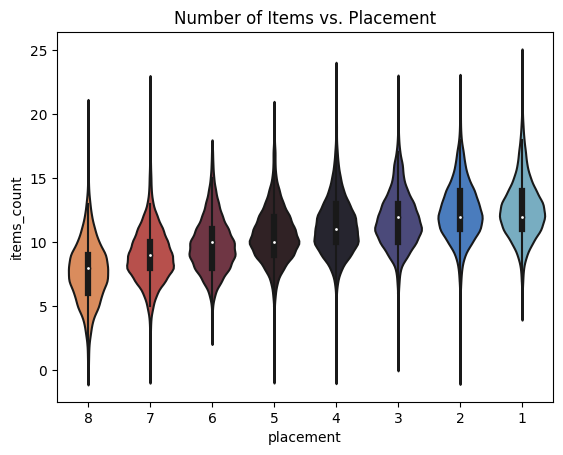

In [6]:
item_plot = sb.violinplot(x = 'placement', y = 'items_count', data = mdf, palette="icefire")
plt.title('Number of Items vs. Placement')
item_plot.invert_xaxis()
plt.show()

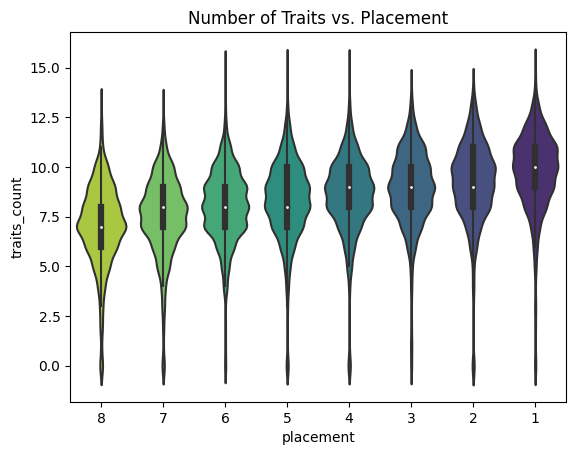

In [7]:
trait_plot = sb.violinplot(x = 'placement', y = 'traits_count', data = mdf, palette="viridis")
plt.title('Number of Traits vs. Placement')
trait_plot.invert_xaxis()
plt.show()

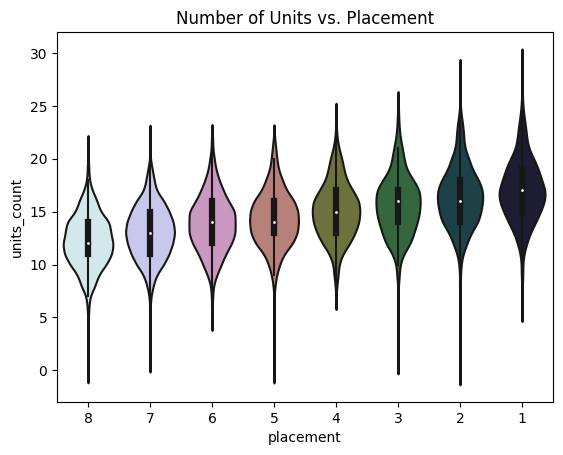

In [8]:
unit_plot = sb.violinplot(x = 'placement', y = 'units_count', data = mdf, palette="cubehelix")
plt.title('Number of Units vs. Placement')
unit_plot.invert_xaxis()
plt.show()

It looks like we may have found some trends! Actually, it looks like each of these graphs has a trend. In order to test whether or not a trend truly exists, let's see how well we can train a linear regression model to predict placement based on each parameter. 

## <center>Predicting Placement</center>

First, let's look at item counts and their relationship to placement.

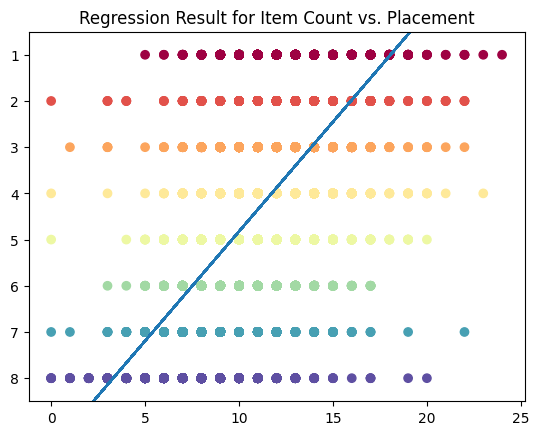

Average accuracy: 0.3262458727990763


In [9]:
items_x_train, items_x_test, items_y_train, items_y_test = train_test_split(mdf.items_count, mdf.placement, random_state=34)

items_reg = linear_model.LinearRegression()

items_x_train = mdf['items_count'].values.reshape(-1,1)
items_y_train = mdf['placement'].values.reshape(-1,1)

items_x_test = mdf['items_count'].values.reshape(-1,1)
items_y_test = mdf['placement'].values.reshape(-1,1)

items_reg.fit(items_x_train, items_y_train)

items_pred = items_reg.predict(items_x_test)

fig,ax = plt.subplots(1)

plt.scatter(items_x_test, items_y_test, c=mdf['placement'],cmap='Spectral')
plt.plot(items_x_test, items_pred)
ax.set_ylim([.5, 8.5])
ax.invert_yaxis()
plt.title("Regression Result for Item Count vs. Placement")

items_score = cross_val_score(items_reg, items_x_train, items_y_train, cv=10)
plt.show()
print("Average accuracy: " + str(items_score.mean()))

Based on this model, there is not a strong enough relationship between item count and placement for a linear regression model to accruately predict placements. Visually, looking at the regression line, one would think there is a clear and obvious relationship, but the regression model we trained can only predict placement with an average error of 0.326. This is way too low to accept as an accurate predictor. Perhaps there is some relationship between the amount of traits played and placement. 

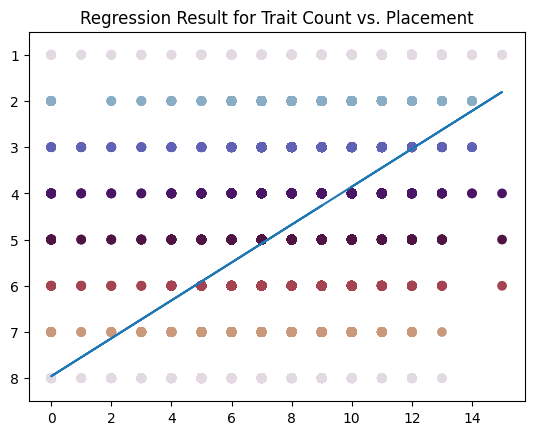

Average accuracy: 0.14710258340166918


In [10]:
traits_x_train, traits_x_test, traits_y_train, traits_y_test = train_test_split(mdf.traits_count, mdf.placement, random_state=34)

traits_reg = linear_model.LinearRegression()

traits_x_train = mdf['traits_count'].values.reshape(-1,1)
traits_y_train = mdf['placement'].values.reshape(-1,1)

traits_x_test = mdf['traits_count'].values.reshape(-1,1)
traits_y_test = mdf['placement'].values.reshape(-1,1)

traits_reg.fit(traits_x_train, traits_y_train)

traits_pred = traits_reg.predict(traits_x_test)

fig,ax = plt.subplots(1)

plt.scatter(traits_x_test, traits_y_test, c=mdf['placement'],cmap='twilight')
plt.plot(traits_x_test, traits_pred)
ax.set_ylim([.5, 8.5])
ax.invert_yaxis()
plt.title("Regression Result for Trait Count vs. Placement")

traits_score = cross_val_score(traits_reg, traits_x_train, traits_y_train, cv=10)
plt.show()
print("Average accuracy: " + str(traits_score.mean()))

Just like with the item count, visually it looks like there should be a trend from the regression line, but the model is even less accurate than the item placement predictor. Will we get a similar result when trying to predict placement with unit counts?

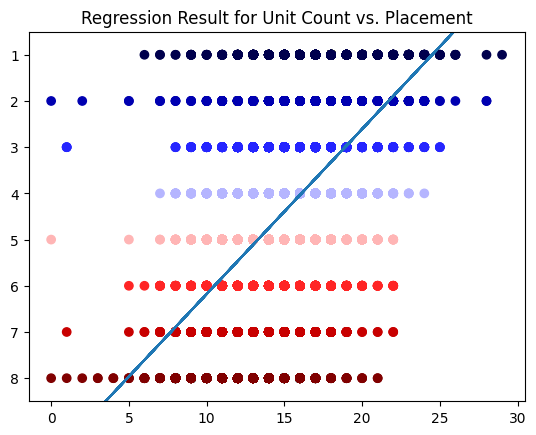

Average accuracy: 0.23774796188143013


In [11]:
units_x_train, units_x_test, units_y_train, units_y_test = train_test_split(mdf.units_count, mdf.placement, random_state=34)

units_reg = linear_model.LinearRegression()

units_x_train = mdf['units_count'].values.reshape(-1,1)
units_y_train = mdf['placement'].values.reshape(-1,1)

units_x_test = mdf['units_count'].values.reshape(-1,1)
units_y_test = mdf['placement'].values.reshape(-1,1)

units_reg.fit(units_x_train, units_y_train)

units_pred = units_reg.predict(units_x_test)

fig,ax = plt.subplots(1)

plt.scatter(units_x_test, units_y_test, c=mdf['placement'],cmap='seismic')
plt.plot(units_x_test, units_pred)
ax.set_ylim([.5, 8.5])
ax.invert_yaxis()
plt.title("Regression Result for Unit Count vs. Placement")

units_score = cross_val_score(units_reg, units_x_train, units_y_train, cv=10)
plt.show()
print("Average accuracy: " + str(units_score.mean()))

The answer is yes, we do. Not quite as inaccurate as the trait placement predictor, but worse than the item placement predictor, there is not a strong enough relationship here for a linear regression model to accurately predict placement of a team based on unit count alone. 

## <center>Analyzing These Results</center>

According to the way TFT works with the item and trait systems, as well as units building off of each other, it seemed logical that there would be a clear relationship between these, and winning. Why did our hypothesis fail?

